In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [191]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)



Число обусловленности такой матрицы будет большим

In [192]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.0426485843, 406095.04267807666)

In [193]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

**Провряем:**

In [194]:
def ConjugateGradient(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    while np.linalg.norm(r) > tol:
        
        #TO DO
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        #END TO DO
        if callback is not None:
            callback(np.linalg.norm(r))
    return x

In [195]:
rk_array = []
callback = lambda x: rk_array.append(x)
_ = ConjugateGradient(x0, A, b, callback=callback)

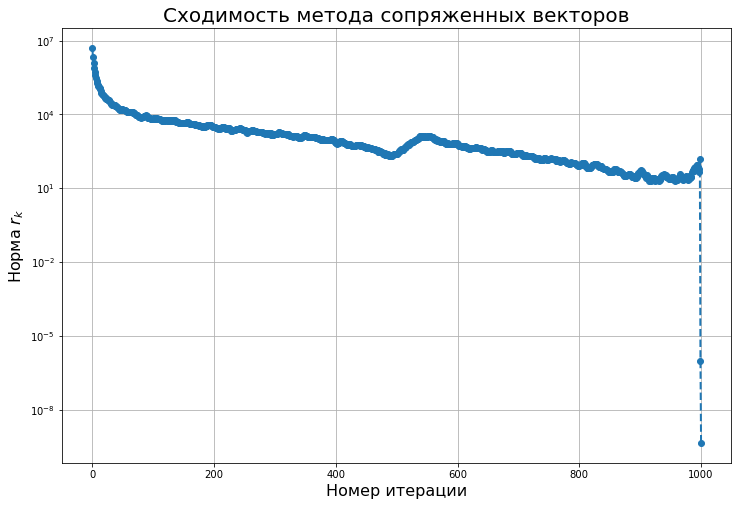

In [196]:
plt.figure(figsize=(12, 8))
plt.title('Сходимость метода сопряженных векторов', fontsize=20)

plt.plot(np.arange(len(rk_array)), rk_array, '--o', linewidth=2, label='Conjugate Gradient')

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Норма $r_k$', fontsize=16)
plt.yscale('log')
plt.grid(b=True)
plt.show()

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [180]:
def helper_func(a, b, c, d):
    return a.T @ b / (c.T @ d)


def PreconditionedCG(x0, A, M, b, tol=1e-8, callback=None):
    x = []
    z = []
    r = []
    alpha = []
    beta = []
    p = []
    
    # Jacobi preconditioner
    #diag_elements = np.diag(A)
    #M = np.zeros(A.shape)
    #for i, diag_element in enumerate(diag_elements):
    #    M[i, i] = diag_element
    
    M_inv = np.linalg.inv(M)
    
    x.append(x0)
    r.append(b - A.dot(x0))
    z.append(M_inv @ r[0])
    p.append(None)
    p.append(z[0])

    w = A @ p[1]
    alpha.append(None)
    alpha.append(helper_func(r[0], z[0], p[1], w))
    x.append(x[0] + alpha[1] * p[1])
    r.append(r[0] - alpha[1] * w)
    k = 1
    
    beta.append(None)
    
    max_k = 1000
    while np.linalg.norm(r[k]) > tol and k < max_k:
        # print(np.linalg.norm(r[-1]))
        z.append(M_inv @ r[k])
        beta.append(helper_func(r[k], z[k], r[k-1], z[k-1]))
        p.append(z[k] + beta[k] * p[k])
        w = A @ p[k + 1]
        alpha.append(helper_func(r[k], z[k], p[k+1], w))
        x.append(x[k] + alpha[k+1] * p[k+1])
        r.append(r[k] - alpha[k+1] * w)
        k = k + 1
        assert(x[-1].shape == x0.shape)

        if callback is not None:
            callback(np.linalg.norm(r[k]))
    return x[-1]

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

Для применения метода сопряженных градиентов необходимо использовать симметричный вариант

$M_{SGS} = (D + L)D^{-1}(D + U)$

In [186]:
A = A.toarray()

In [187]:
diag_elements = np.diag(A)
D = np.zeros(A.shape)
for i, diag_element in enumerate(diag_elements):
    D[i, i] = diag_element
L = np.tril(A, -1) # нижний треугольник
U = np.triu(A, 1) # верхний треугольник
M = (D + L) @ np.linalg.inv(D) @ (D + U)

max_diff = -1
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        max_diff = max(max_diff, np.abs(M[i,j] - M[j, i]))
print(max_diff)

0.0


In [188]:
rk_array2 = []
callback2 = lambda x: rk_array2.append(x)
_ = PreconditionedCG(x0, A, M, b, callback=callback2)

rk_array = []
callback = lambda x: rk_array.append(x)
_ = ConjugateGradient(x0, A, b, callback=callback)

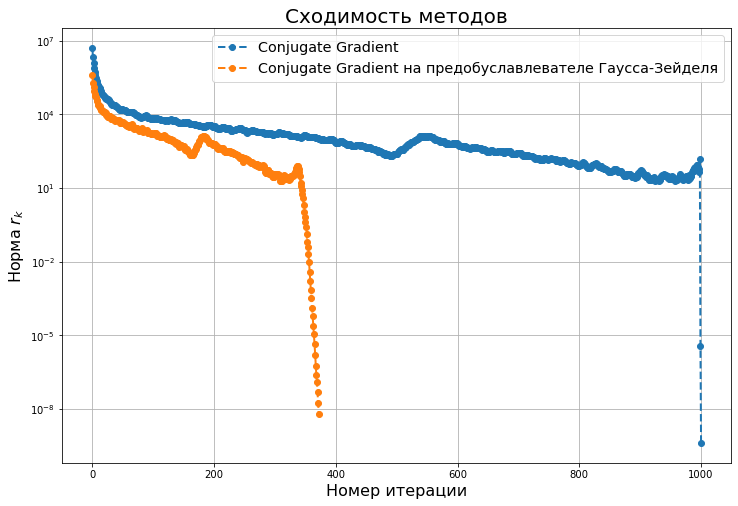

In [190]:
plt.figure(figsize=(12, 8))
plt.title('Сходимость методов', fontsize=20)

plt.plot(np.arange(len(rk_array)), rk_array, '--o', linewidth=2, label='Conjugate Gradient')
plt.plot(np.arange(len(rk_array2)), rk_array2, '--o', linewidth=2, label='Conjugate Gradient на предобуславлевателе Гаусса-Зейделя')

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Норма $r_k$', fontsize=16)
plt.yscale('log')
plt.grid(b=True)
plt.legend(fontsize='x-large')
plt.show()

Сравните результат работы предобусловленной и непредобусловленной версии

Как видим из графиков, с предобуславливателем Гаусса-Зейделя сходимость наступает быстрее 

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [197]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)

# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])

# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

In [238]:
# Код градиентного спуска и метода Нестерова с семинара
# + код Momentum

import types

def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha


def Momentum(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1 = 0.3, momentum=0.9, gamma=1.0):
    x = x0.copy()
    iteration = 0
    conv_array = []

    v = 0

    while True:
        beta2 = 1. -beta1
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * (gradient - gamma * v)

        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
        
        v = momentum * v - (1 - momentum) * gradient
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []
  
    while True:
        beta2 = 1. -beta1
        #TO DO
        alpha = backtracking(x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        #TO DO
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

In [263]:
res_nest = NesterovAcceleratedGD(f, grad_f, x0, momentum =0.15)
x_na, y_na = get_x_y_from_callback(res_nest["conv_array"], x0)

res = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_gd, y_gd = get_x_y_from_callback(res['conv_array'], x0)

res_momentum = Momentum(f, grad_f, x0, rho=0.5, beta1=0.2, momentum=0.9, gamma=1)
x_momentum, y_momentum = get_x_y_from_callback(res_momentum['conv_array'], x0)

method_names = ('Gradient Descent', 'NA Gradient Descent', 'Momentum')

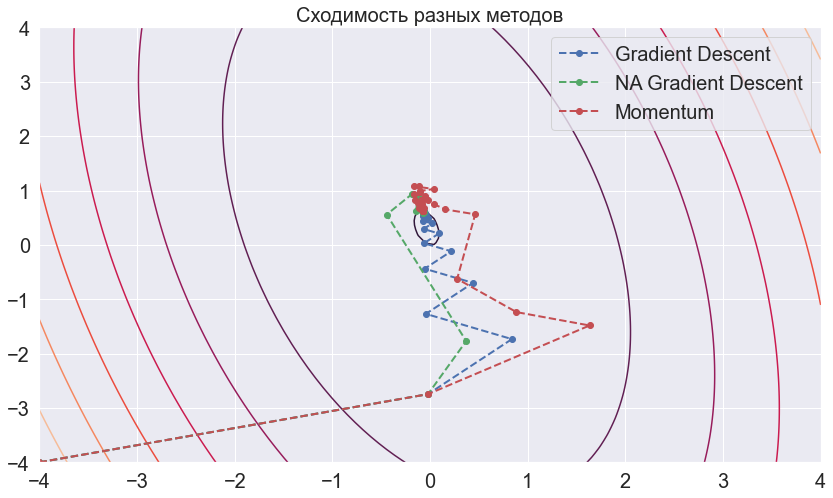

In [264]:
plt.figure(figsize = (14, 8))
plt.title('Сходимость разных методов', fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(x_gd, y_gd, '--bo',linewidth=2, label='Gradient Descent')
plt.plot(x_na, y_na ,'--go', linewidth=2, label='NA Gradient Descent')
plt.plot(x_momentum, y_momentum, '--ro', linewidth=2, label='Momentum')

plt.legend(loc="best", fontsize=20)
plt.contour(x, y, f_x)
plt.show()

In [265]:
for method_name, result in zip(method_names, (res, res_nest, res_momentum)):
    print(f'method: {method_name}, result: {result["x"]}, num_iter: {result["num_iter"]}, tol: {result["tol"]}')

method: Gradient Descent, result: [-0.07127272  0.62967031], num_iter: 70, tol: 9.433065185495247e-09
method: NA Gradient Descent, result: [-0.07127272  0.62967032], num_iter: 31, tol: 8.730884368119756e-09
method: Momentum, result: [-0.07127272  0.62967032], num_iter: 100, tol: 6.202928146909637e-09


Как видим, быстрее всего сходится метод Нестерова, Моментум - медленнее всего